<a href="https://colab.research.google.com/github/ritwiks9635/Optical-Character-Recognition-Model/blob/main/OCR_Model_using_CTCLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Optical Character Recognition**

In [1]:
#https://www.kaggle.com/datasets/fournierp/captcha-version-2-images

In [ ]:
!pip install keras --upgrade

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops

import matplotlib.pyplot as plt

## **Prepare Dataset**

In [6]:
data_dir = "/content/samples"

image_paths = []


for i in os.listdir(data_dir):
    if i.endswith(".png"):
        img_path = os.path.join(data_dir, i)
        #img_path = sorted(str(img_path))
        image_paths.append(img_path)
image_paths = sorted(image_paths)
labels = [str(img_path).split("/")[3].split(".png")[0] for img_path in image_paths]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

max_len = max([len(label) for label in labels])

print("Total Image paths is :: ", len(image_paths))
print("Total Label is :: ", len(labels))
print("Total unique characters is :: ", len(characters))
print("Unique characters is :: ", characters)
print("Maximum Length of character is :: ", max_len)

Total Image paths is ::  1040
Total Label is ::  1040
Total unique characters is ::  19
Unique characters is ::  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Maximum Length of character is ::  5


In [7]:
batch_size = 16
img_height = 50
img_width = 200
downsample_factor = 4

In [8]:
char_to_num = layers.StringLookup(vocabulary = list(characters), mask_token = None)
num_to_char = layers.StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [9]:
def split_data(images, labels, train_size = 0.9, shuffle = True):
    size = len(images)
    idx = ops.arange(size)

    if shuffle:
        idx = keras.random.shuffle(idx)

    train_samples = int(size * train_size)
    x_train, y_train = images[idx[: train_samples]], labels[idx[: train_samples]]
    x_valid, y_valid = images[idx[train_samples :]], labels[idx[train_samples :]]
    return x_train, y_train, x_valid, y_valid


x_train, y_train, x_valid, y_valid = split_data(np.array(image_paths), np.array(labels))

In [10]:
def preprocess_data(img_path, label):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_png(image, channels = 1)
    image = tf.image.convert_image_dtype(image, dtype = tf.float32)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.transpose(image, [1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": image, "label": label}

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_dataset = valid_dataset.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)

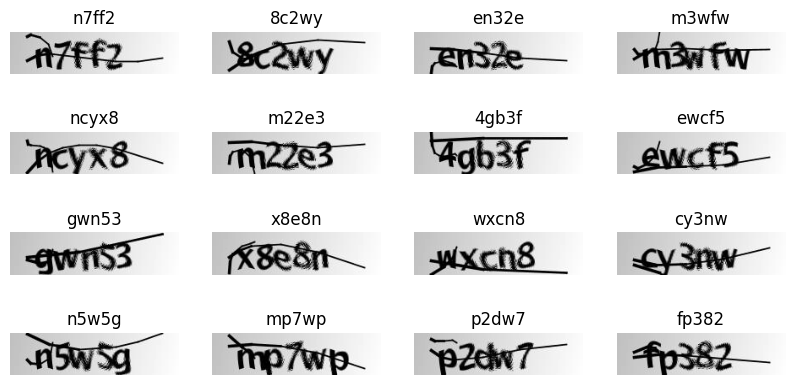

In [12]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## **Build Model**

In [13]:
def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64")
    )

In [14]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(ctc_label_dense_to_sparse(y_true, label_length), dtype="int32")

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )

In [15]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [16]:
def build_model():
    input_img = layers.Input(shape = (img_width, img_height, 1), name = "image", dtype = "float32")
    input_lab = layers.Input(shape = (None,), name = "label", dtype = "float32")

    x = layers.Conv2D(32, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", name = "conv1")(input_img)
    x = layers.MaxPooling2D(pool_size = (2, 2), name = "pool1")(x)

    x = layers.Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal", name = "conv2")(x)
    x = layers.MaxPooling2D(pool_size = (2, 2), name = "pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True, dropout = 0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation = "softmax", name = "dense2")(x)
    outputs = CTCLayer(name = "ctc_loss")(input_lab, x)
    model = keras.Model(inputs = [input_img, input_lab], outputs = outputs)

    optimizer = keras.optimizers.Adam()
    model.compile(optimizer = optimizer)

    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 21)         │          2,709 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 21)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 10, restore_best_weights = True)

history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 100,
    callbacks = [early_stopping_cb])

## **Prediction**

In [18]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)

In [23]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


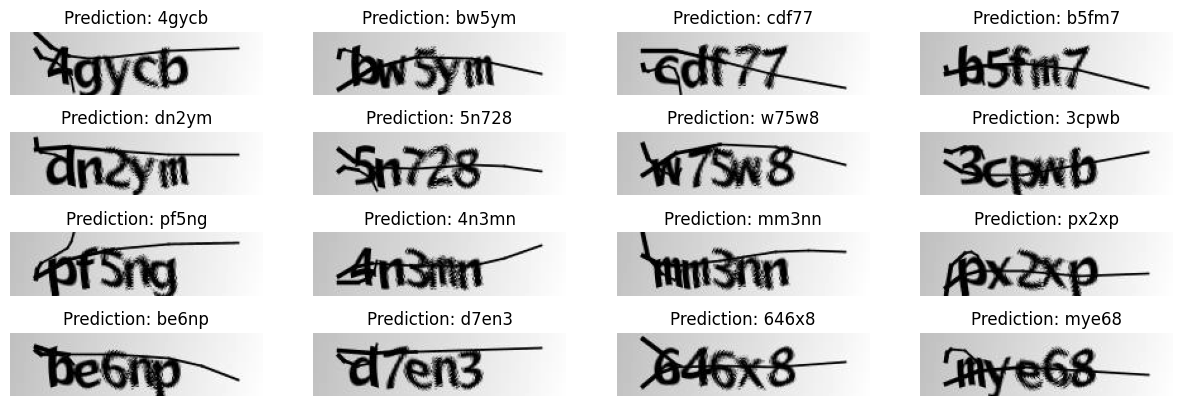

In [24]:
prediction_model = keras.Model(model.input[0], model.get_layer(name="dense2").output)

#  Let's check results on some validation samples
for batch in valid_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()